# Exploration_09 - 9. 폐렴 진단기 성능 향상!

| 목표|   세부 내용|
|:-|:-|
|1. **정확도 85%에 도달**| |
|2. 과대적합을 완화|    규제 방법 선택|
|3. 시각화로 확인| |

## 목차
---





|**루브릭** |
|:-|
|아래의 기준을 바탕으로 프로젝트를 평가합니다. | 


|**평가문항**|**상세기준**|
|:-|:-|
|1. 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다.|모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.|
|2. 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.|regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다.|
|3. 실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다.|Accuracy 기준 85%에 도달하였다.|

---

 **Overfitting을 완화시키는 방법**

---
**1. Training Data를 늘린다.**
- 학습시간이 늘어나기 때문에 그만큼 비용도 늘어나서 효율적이지 않다. : augmentation은 이에 해당되며, 데이터 증가(Data Augmentation)

**2. Regularization(규제)**
- W(weight)가 너무 큰 값들을 가지지 않도록 하는 것

**3. Drop-Out(신경망에서 쓰는 규제)**
- 확률적으로 랜덤하게 뉴런의 가중치를 0로 중요 가중치의 비중을 줄여준다
---
**regularization(규제)**

---
- Overfitting(과대적합)을 방지하기 위함 : optimization(최적화) - 적정적합을 하기 위함
1. L1 Regularization(L1 규제) 
2. L2 Regularization(L2 규제)

**Data Augmentation(데이터 증가)**
- 데이터를 늘려서 학습량이 늘어나면서 이에 따라 집중되는 가중치 또한 줄어든다

**ablation study**
- 모델간의 성능을 비교하는데 사용
- feature를 제거한 모델들끼리의 성능 비교
- 우수한 지 여부를 파악

## 1. Set-up
- 이번 프로젝트에서 사용할 패키지 목록

In [70]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

## 변수 생성

In [71]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 64 # 기존 16 -> 64 / NOTE : 64면 64개의 데이터에 대해 예측한 뒤 실제 레이블 값과 비교하여 가중치 갱신도 64번 발생한다
EPOCHS = 35 # 기존 25 -> 35 / NOTE : 35이면 반복학습 횟수 35번

print(ROOT_PATH)

/aiffel/aiffel


## 2. 데이터 가져오기

In [72]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


**val 데이터가 16개로 적기 때문에 train 데이터에서 70:30으로 분할하도록 하겠습니다.**

In [73]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8) # test_size를 수정하면 개수는 달라질 수 있습니다.
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


**데이터 분할로 인해서 트레이닝 데이터와 검증데이터의 데이터가 70:30으로(적절하게) 분배되었습니다.**
- Train Data : 5216-> 4185 / 데이터 감소
- val data : 16 -> 1047 / 데이터 증가

**정상(Normal) 이미지와 폐렴(Pneumonia) 이미지를 구분**

In [74]:
print(f'Normal image path\n{filenames[0]}') # 정상 이미지
print(f'Pneumonia image path\n{filenames[2000]}') # 폐렴 이미지

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


**파일 경로에 파일이름으로 확인 / 정상(Normal) 이미지와 폐렴(Pneumonia) 이미지 수 확인**

In [75]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


**Normal images count in training set: 1072 :** <span style="color:blue">**정상이미지 1072개**</span>

**Pneumonia images count in training set: 3113 :**<span style="color:red"> **폐렴이미지 3113개**</span>


- 결과를 보면 정상보다 폐렴 이미지 수가 3배 더 많이 있습니다.
- 우리가 사용할 CNN 모델의 경우 데이터가 클래스별 balance가 좋을수록 training을 잘 합니다. 
- 데이터가 클래스 불균형(imbalance)한 것은 차후에 조정할 예정입니다.
- test와 val 데이터셋은 평가하기 위해서 사용되기 때문에 학습과 관련이 없으므로 imbalance한 데이터 셋이어도 문제없습니다.

#### tf.data 인스턴스를 만들고 트레이닝 리스트와 검증 리스트 변수에 할당

In [76]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

**Train 데이터셋, validation 데이터셋 개수 확인**

In [77]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


#### 현재 이미지에는 라벨 데이터가 따로 없습니다.
- 파일 경로에 'NORMAL'이나 'PNEUMONIA'가 포함되어 있기 때문에 이를 이용해서 라벨 데이터를 만들어 주는 함수를 만들기

In [78]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

#### 이미지 데이터는 현실적으로 사이즈가 제각각일 가능성이 높습니다.
- 이미지의 사이즈를 통일 시키고 GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 줄여봅시다.
- decode_img 함수와 process_path 함수를 만들겠습니다.
---
- process_path 함수에서 decode_img 함수를 이용해서 이미지의 데이터 타입을 float으로 바꾸고 사이즈를 변경합니다.
- get_label을 이용해서 라벨 값을 가져옵니다.

In [79]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

#### train 데이터 셋과 validation 데이터 셋을 만듭니다.
- num_parallel_calls 파라미터에 위에서 할당한 <span style="color:red">**AUTOTUNE변수를 이용하면 더욱 빠르게 데이터를 처리해 줄 수 있습니다.**</span>

In [80]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

**이미지가 잘 리사이즈 되었는지, 그리고 라벨이 잘 들어가 있는지 확인해봅시다.**

In [81]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


**FIXME : Label : False로 나오는 것은 잘 안된 것 같은데요**

**사이즈가 잘 변환되어 있고 라벨도 잘 들어가 있군요! 참고로, 코드에서**<span style="color:red">**train_ds.take(1)은 하나의 데이터만 가져온다는 의미입니다.**</span>

---
**위에서 train과 validation 데이터셋을 만든 것처럼 test 데이터셋도 만들어 보겠습니다. 그리고 데이터 개수도 확인해보겠습니다.**

In [82]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


**Test dataset : 624**

shuffle()을 사용하며 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택

repeat()를 사용하면 epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데,
이때 repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용할 수 있게 해줍니다.
repeat()를 사용하면 자동으로 데이터를 맞춰줍니다.

batch()를 사용하면 BATCH_SIZE에서 정한 만큼의 배치로 주어집니다.
예를 들어, 100개의 데이터를 10개의 배치로 나누게 되면 각 배치에는 10개의 데이터로 나뉘게 됩니다.

prefetch()를 사용하면 학습 데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있습니다.

In [83]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## 3. 데이터 시각화
데이터를 보기 위해 먼저, train에 있는 batch 중 첫 번째 배치를 추출합니다. 추출된 배치를 image와 label 데이터 셋으로 나눕니다. 이제 show_batch() 함수를 이용해서 결과 사진을 보겠습니다.

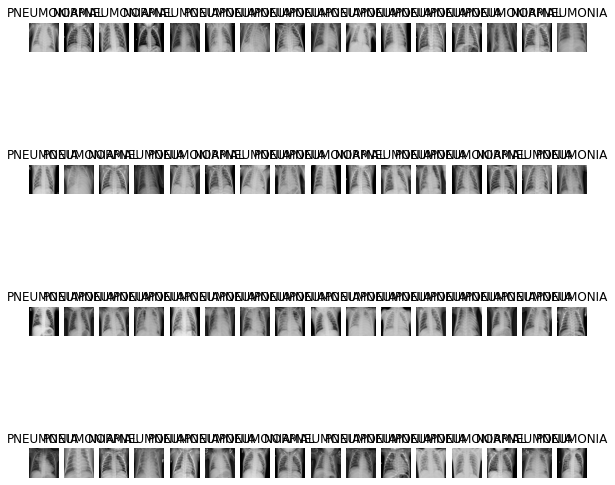

In [84]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## 4. CNN 모델링
- 이미지 처리에 특화된 딥러닝 모델인 CNN
- Convolution block을 만듭니다. conv_block()의 구성은 Convolution을 두 번 진행하고 Batch Normalization을 통해서 Gradient vanishing, Gradient Exploding을 해결합니다. 그리고 Max Pooling을 합니다.

In [85]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

### Dense Block 만들기

In [86]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

- 방금 만들어진 모델에는 Batch Normalization과 Dropout이라는 두 가지 regularization 기법이 동시에 사용되고 있습니다.
- 일반적으로 이런 방법은 잘 사용되지 않거나, 금기시되기도 합니다.
---
- variance shift를 억제하는 Batch Normalization과 이를 유발하는 Dropout을 동시에 사용하는 것이 어울리지 않는다고 밝히고 있습니다.
- 실용적으로는 두 방법을 같이 쓰는 것이 낫다고 보는 견해도 없는 것은 아닙니다. 예외적으로 동시에 사용하는 것이 성능 향상에 도움을 주는 경우가 실제로 있습니다.
---
**이번 실습에서는 두 가지를 함께 사용하는 이 모델이 성능 향상에 도움이 될지 여부도 흥미롭게 살펴볼만 한 부분입니다.**



In [87]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## 5. 데이터 imbalance 처리
- 'Normal'과 폐렴에서 'Pneumonia' 중에 'Pneumonia' 데이터가 많이 있었죠? 한 라벨이 너무 많은 경우를 imbalance 하다고 하는데, 데이터를 학습할 때 imbalance한 데이터의 경우 학습 효과가 좋지 않을 수 있습니다.
---
- 이런 문제들을 해결하는 방법으로 Weight balancing이라는 테크닉이 사용됩니다. Weight balancing 은 training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법입니다. Keras는 model.fit()을 호출할 때 파라미터로 넘기는 class_weight 에 이러한 클래스별 가중치를 세팅할 수 있도록 지원하고 있습니다. 
---
- weight_for_0은 'Normal' 이미지에 사용할 weight를, weight_for_1은 'Pneumonia' 이미지에 사용할 weight를 세팅합니다. 이 weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정

In [88]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


## 6. 모델 훈련
- 이미지 훈련은 GPU를 사용할 것이기 때문에 먼저 GPU를 선택합니다. 모델은 위에서 만들었던 모델 함수인 build_model()을 model에 선언
---
- 이미지의 라벨이 두 개밖에 없기 때문에 "binary_cross entropy" loss를 사용합니다. optimizer로 'adam'을 사용합니다.
- 성과에 대해서 측정하기 위한 metrics으로 'accuracy', 'precision', 'recall'을 사용

In [89]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

- 모델을 fit 해보겠습니다. 각 파라미터에 위에서 선언했었던 변수, 데이터 셋을 가져와서 각각에 맞게 넣어줍니다.
- (모델 학습시 약 20분 이상 소요 됩니다.)

In [90]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/35
65/65 [==============================] - 59s 773ms/step - loss: 0.3991 - accuracy: 0.7978 - precision: 0.9552 - recall: 0.7641 - val_loss: 0.5794 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 2/35
65/65 [==============================] - 47s 737ms/step - loss: 0.1899 - accuracy: 0.9260 - precision: 0.9780 - recall: 0.9211 - val_loss: 0.7569 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 3/35
65/65 [==============================] - 48s 751ms/step - loss: 0.1610 - accuracy: 0.9411 - precision: 0.9818 - recall: 0.9384 - val_loss: 0.8617 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 4/35
65/65 [==============================] - 49s 765ms/step - loss: 0.1330 - accuracy: 0.9591 - precision: 0.9854 - recall: 0.9592 - val_loss: 1.0106 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 5/35
65/65 [==============================] - 51s 800ms/step - loss: 0.1271 - accuracy: 0.9591

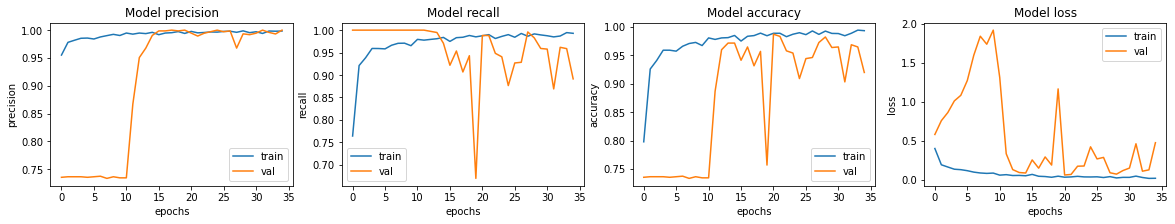

In [91]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [92]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

10/10 [==============================] - 4s 394ms/step - loss: 0.7092 - accuracy: 0.8622 - precision: 0.8519 - recall: 0.9436
Loss: 0.7092134952545166,
Accuracy: 0.8621794581413269,
Precision: 0.8518518805503845,
Recall: 0.9435897469520569


# 회고
### 1. Accuracy: 0.8621794581413269 정확도 : 86% - 많은 시도 끝에 이뤄냈다. (86% 성공)
### 2. 포인트는 바로 비치사이즈와 에포크였다. : 에포크의 수를 높였고 비치사이즈 또한 높였다.
###     - 비치사이즈는 2배로 높였고 에포크의 수는 5회씩 변화를 주었다
### 3. 학습을 많이 하다보니 실패하는 경우가 발생하면 다시 또 다시 이러한 걸 반복하다보니 데이터를 학습하는 건지
###  - 나 자신을 학습하고 인내를 배우는 건지 구분하기 힘들정도였다. 많은 시간 투자가 이루어졌다.

# 끝으로
### 시간은 금이라는 데 학습하는 시간은 정말 금인가?라는 생각이 들었고 더 빨리 학습하는 방법이 없을까라는 생각이 많이 들었다. GPU가 높은 PC로 학습을 해야하는 건데 노트북으로 학습을 해서 더 더딘 느낌이다
- 다음엔 PC로 해야 겠다. RTX로 한번 달려보자~
